In [1]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os

%matplotlib inline
plt.ion()   # interactive mode

In [2]:
##############################################
# STEP 1:  LOAD DATA, DEFINE BATCHES         #
##############################################

input_size = 224 #for resnet
#input_size = 227 #for alexnet

data_transforms = {
    'train': transforms.Compose([
        transforms.Scale(input_size),
        #transforms.RandomSizedCrop(input_size),
        #transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Scale(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'baby7aug'  #select data source
inc_test = True

if inc_test ==False:
    dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['train', 'val']}
    dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=32,
                                               shuffle=True, num_workers=4)
                for x in ['train', 'val']}
    dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}

else:

    dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
             for x in ['train', 'val', 'test']}
    dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=32,
                                                   shuffle=True, num_workers=4)
                    for x in ['train', 'val', 'test']}
    dset_sizes = {x: len(dsets[x]) for x in ['train', 'val', 'test']}




dset_classes = dsets['train'].classes
print (dset_classes)
print (dset_sizes)
use_gpu = torch.cuda.is_available()

['care', 'empty', 'sit', 'sleep', 'stand']
{'test': 269, 'train': 6644, 'val': 570}


In [3]:
##############################################
# STEP 3:  DEFINE TRAIN MODEL                #
##############################################

def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=25, val_check=True, verbose=False, lr=0.001):
    since = time.time()

    best_model = model
    best_acc = 0.0
    training_data = []
    val_acc = []
    train_loss = []
    train_acc = []
    validation_acc =0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch, lr)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, data in enumerate(dset_loaders[phase]):
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), \
                        Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
                batch_acc = torch.sum(preds == labels.data) / 32 #hardcoded batchsize
                
                # print out results per batch & save to array
                if verbose:
                    print('{} Loss - batch {}: {:.4f} Acc: {:.4f} Val Acc:{:.4f}'.format(
                            phase, i, loss.data[0], batch_acc, validation_acc))
                train_loss.append(loss.data[0])
                train_acc.append(batch_acc)
                
                # validation check per batch & save to array
                if val_check:
                    validation_acc = accuracy_check(model_ft, verbose=False, phase="val")
                    val_acc.append(validation_acc)
                    #print('val accuracy check: {:.4f}'.format(validation_acc))

            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects / dset_sizes[phase]
            validation_acc = accuracy_check(model_ft, verbose=False, phase="val")
            print('Train Loss: {:.4f} Train Acc: {:.4f} Val Acc:{:.4f}'.format(epoch_loss, epoch_acc, validation_acc))

            # deep copy the model
            if validation_acc > best_acc:
                best_acc = validation_acc
                best_model = copy.deepcopy(model)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return best_model, best_acc, train_loss, train_acc, val_acc

In [4]:
def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

def accuracy_check(model, verbose=True, verbose_img=False, phase="val"):
    
    tot_matrix = np.zeros((5, 5))
    acc_matrix = np.zeros((5, 5), dtype=float)
    #images_so_far = 0
    
    # Iterate over data.
    for i, data in enumerate(dset_loaders[phase]):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), \
                Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        # loops through each item in the batch
        for j in range(inputs.size()[0]):
            tot_matrix[preds[j][0]][labels.data[j]] += 1
            
            # if verbose_img flag is on then show wrong ones
            if verbose_img and (preds[j][0]!=labels.data[j]):
                plt.figure(figsize=(50,20))
                titletxt = 'predicted: {}, actual:{}'.format(dset_classes[preds[j][0]], dset_classes[labels.data[j]])
                imshow(inputs.cpu().data[j], title=titletxt)
                #imshow(inputs.cpu().data[j])
                
    
    acc_matrix = tot_matrix / np.sum(tot_matrix,axis=0)
    np.set_printoptions(precision=2)
    accuracy = np.sum(np.identity(5)*tot_matrix)/np.sum(tot_matrix)
    
    
    if verbose:
        print('{} Accuracy = {:.4f}'.format(phase, accuracy))
        print(np.sum(tot_matrix,axis=0))
        print('total samples: {:.2f}'.format(np.sum(tot_matrix)))
        print("Accuracy")
        print(acc_matrix)
        print("Total")
        print(tot_matrix)
    
    return accuracy

In [5]:
'''
#-----------------------------------------------------------
#ResNet
#-----------------------------------------------------------

model_ft = models.resnet18(pretrained=True)

#freeze weights in ResNet
for param in model_ft.parameters():
    param.requires_grad = True

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 5)
'''
'''
#-----------------------------------------------------------
#AlexNet  (note!  need to change input size to 227 not 224)
#-----------------------------------------------------------
model_ft = models.alexnet(pretrained=True)
#print (list(model_ft_temp.classifier.children()))
#print (list(list(model_ft_temp.classifier.children())[1].parameters()))
mod = list(model_ft.classifier.children())
mod.pop()
mod.append(torch.nn.Linear(4096, 5))
new_classifier = torch.nn.Sequential(*mod)
#print (list(list(new_classifier.children())[1].parameters()))
model_ft.classifier = new_classifier

'''

#-----------------------------------------------------------
#SqueezeNet 1.1
#-----------------------------------------------------------
model_ft = models.squeezenet1_1(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = True

model_ft.num_classes = 5

new_classifier = nn.Sequential(
                nn.Dropout(p=0.5),
                nn.Conv2d(512, 5, kernel_size=1),
                nn.ReLU(inplace=True),
                nn.AvgPool2d(13)
            )
    
model_ft.classifier = new_classifier
    
    
    

best_val_acc = 0

loops = 10

for i in range(loops):
    
    #lrtest = 10.0**(-1*np.random.uniform(3,4))
    #lrtest = 0.00026
    lrtest = np.random.uniform(0.001, 0.0001)
    if use_gpu:
        model_ft = model_ft.cuda()
        
    #class_weights = torch.cuda.FloatTensor((0.1,0.1,0.1,0.01,100))
    class_weights = torch.cuda.FloatTensor((0.4,0.15,0.132,0.025,0.07))
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    #criterion = nn.CrossEntropyLoss()

    #for changing weights
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=lrtest, momentum=0.9)
    
    #for fixed weights
    #optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=lrtest, momentum=0.9)

    model_ft, best_acc, train_loss_array, train_acc_array, val_acc_array = train_model(model_ft, criterion, optimizer_ft, 
                        exp_lr_scheduler,num_epochs=2, val_check=False, verbose=False, lr=lrtest)
    
    if best_val_acc < best_acc:
        best_val_acc = best_acc
        best_model = model_ft

print ('Best Validation Accuracy = {:.4f}'.format(best_val_acc)) 


Epoch 0/1
----------
LR is set to 0.00019601905020710125
Train Loss: 0.0314 Train Acc: 0.6443 Val Acc:0.8596

Epoch 1/1
----------
Train Loss: 0.0176 Train Acc: 0.8204 Val Acc:0.8561

Training complete in 2m 55s
Best val Acc: 0.859649
Epoch 0/1
----------
LR is set to 0.0004914089956027889
Train Loss: 0.0190 Train Acc: 0.7932 Val Acc:0.8737

Epoch 1/1
----------
Train Loss: 0.0109 Train Acc: 0.8764 Val Acc:0.9228

Training complete in 2m 17s
Best val Acc: 0.922807
Epoch 0/1
----------
LR is set to 0.0006984560132174476
Train Loss: 0.0093 Train Acc: 0.9022 Val Acc:0.8421

Epoch 1/1
----------
Train Loss: 0.0064 Train Acc: 0.9255 Val Acc:0.9070

Training complete in 2m 18s
Best val Acc: 0.907018
Epoch 0/1
----------
LR is set to 0.0003444541068157595
Train Loss: 0.0032 Train Acc: 0.9622 Val Acc:0.9579

Epoch 1/1
----------
Train Loss: 0.0026 Train Acc: 0.9672 Val Acc:0.9667

Training complete in 2m 17s
Best val Acc: 0.966667
Epoch 0/1
----------
LR is set to 0.00020193544048334997
Train 

In [6]:
torch.save(best_model, 'weightedloss_lrloop_SqueezeNet1_1_baby7aug.pt')

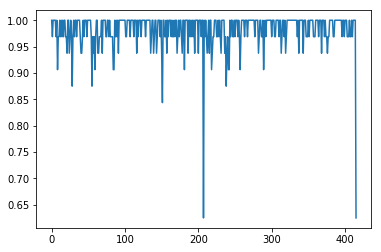

In [7]:
# Graph of train and val accuracies

plt.plot(train_acc_array)
plt.plot(val_acc_array)

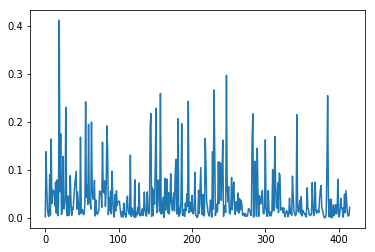

In [8]:
plt.plot(train_loss_array)

In [9]:
accuracy_check(model_ft, verbose=True, verbose_img=False, phase="train")

train Accuracy = 0.9926
[  144.   768.   704.  3868.  1160.]
total samples: 6644.00
Accuracy
[[  1.00e+00   0.00e+00   0.00e+00   1.03e-03   1.72e-03]
 [  0.00e+00   9.99e-01   0.00e+00   5.17e-04   0.00e+00]
 [  0.00e+00   0.00e+00   9.91e-01   3.36e-03   1.64e-02]
 [  0.00e+00   1.30e-03   8.52e-03   9.95e-01   0.00e+00]
 [  0.00e+00   0.00e+00   0.00e+00   5.17e-04   9.82e-01]]
Total
[[  1.44e+02   0.00e+00   0.00e+00   4.00e+00   2.00e+00]
 [  0.00e+00   7.67e+02   0.00e+00   2.00e+00   0.00e+00]
 [  0.00e+00   0.00e+00   6.98e+02   1.30e+01   1.90e+01]
 [  0.00e+00   1.00e+00   6.00e+00   3.85e+03   0.00e+00]
 [  0.00e+00   0.00e+00   0.00e+00   2.00e+00   1.14e+03]]


0.99262492474413

In [10]:
accuracy_check(model_ft, verbose=True, verbose_img=False, phase="val")

val Accuracy = 0.9561
[   9.   55.   69.  341.   96.]
total samples: 570.00
Accuracy
[[ 0.89  0.    0.    0.    0.02]
 [ 0.    0.96  0.04  0.    0.03]
 [ 0.    0.    0.87  0.    0.01]
 [ 0.11  0.02  0.07  0.99  0.05]
 [ 0.    0.02  0.01  0.    0.89]]
Total
[[   8.    0.    0.    0.    2.]
 [   0.   53.    3.    1.    3.]
 [   0.    0.   60.    1.    1.]
 [   1.    1.    5.  339.    5.]
 [   0.    1.    1.    0.   85.]]


0.95614035087719296

In [11]:
accuracy_check(model_ft, verbose=True, verbose_img=False, phase="test")

test Accuracy = 0.9814
[   6.   31.   24.  154.   54.]
total samples: 269.00
Accuracy
[[ 0.67  0.    0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.02]
 [ 0.33  0.    1.    0.01  0.02]
 [ 0.    0.    0.    0.99  0.  ]
 [ 0.    0.    0.    0.    0.96]]
Total
[[   4.    0.    0.    0.    0.]
 [   0.   31.    0.    0.    1.]
 [   2.    0.   24.    1.    1.]
 [   0.    0.    0.  153.    0.]
 [   0.    0.    0.    0.   52.]]


0.98141263940520451

In [ ]:
##############################################
# SHOW IMAGES IN DATASET (OPTIONAL)          #
##############################################

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dset_loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

plt.figure(figsize=(50,20))
imshow(out, title=[dset_classes[x] for x in classes])

In [17]:
torch.save(model_ft, 'lilymodel3_randomhorizontalflip.pt')